In [141]:
import sys

sys.path

sys.path.append("/Users/hanne/PyCharmProjects/CycleStats")

In [142]:
import sourcetocsv as cycle
import numpy as np
import pandas as pd
import thinkstats2 as ts
import thinkplot as tp

In [143]:
filepath = 'C:/Users/hanne/PycharmProjects/CycleStats/RideAnalysisExperiments/RideAnalysisFinal/'
#filepath = '/Users/hbuhrmann/PycharmProjects/CycleStats/TestResults2/'

filename= '_fin_2020-02-14 10h41m51.csv'

cycledf=cycle.getfinalcsvcycledata(filepath,filename)

In [144]:
cycledf['5minslot']=np.floor(cycledf.CumMoveDuration/5/60)
cycledf['elepos']=cycledf.Elevation.apply(lambda x: 0 if x < 0 else x)
cycledf['eleneg']=cycledf.Elevation.apply(lambda x: 0 if x > 0 else x)


In [145]:
powerspeed = cycledf.groupby(['ActivityId','5minslot'])['ElapsedDuration','CumMoveDuration','CumDistXYZ','CumMeasuredWork','HeartRate'].max()
powerspeed.rename(columns={'HeartRate':'MaxHeartRate'},inplace=True)
elevations = cycledf.groupby(['ActivityId','5minslot'])['elepos','eleneg','Elevation','Duration','StationaryDuration','TotalMeasuredWork'].sum()
cadences = cycledf.groupby(['ActivityId','5minslot'])['Cadence','HeartRate'].mean()
intervals = pd.concat([powerspeed,elevations,cadences],axis=1)

In [146]:
intervals['5minutespower']=intervals.CumMeasuredWork/intervals.CumMoveDuration

In [147]:
intervals.columns

Index(['ElapsedDuration', 'CumMoveDuration', 'CumDistXYZ', 'CumMeasuredWork',
       'MaxHeartRate', 'elepos', 'eleneg', 'Elevation', 'Duration',
       'StationaryDuration', 'TotalMeasuredWork', 'Cadence', 'HeartRate',
       '5minutespower'],
      dtype='object')

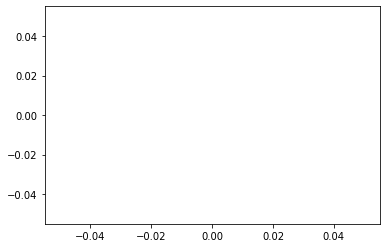

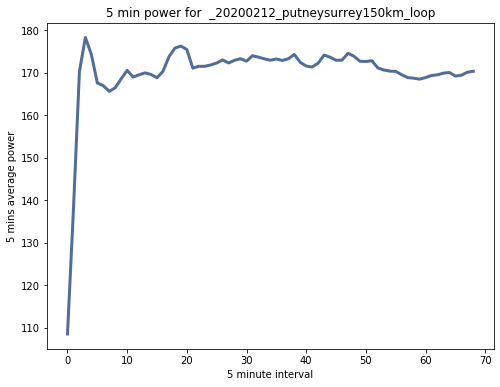

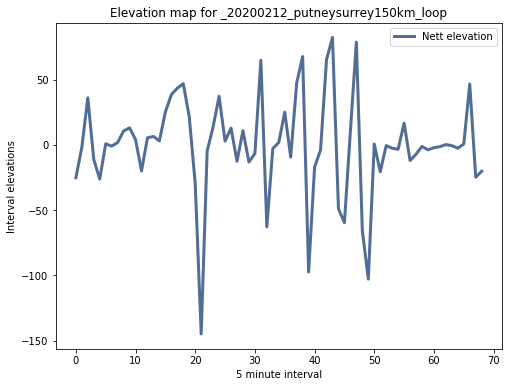

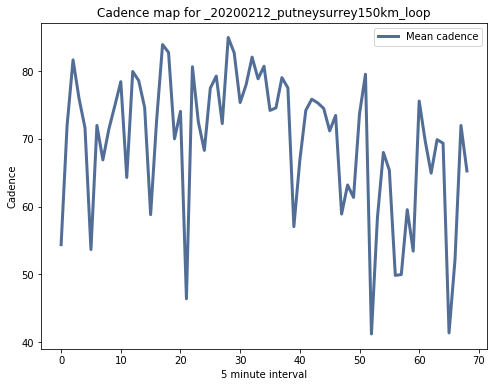

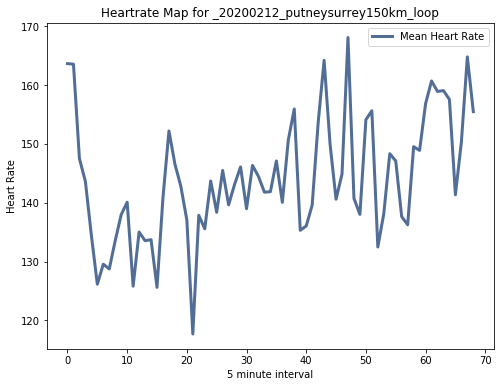

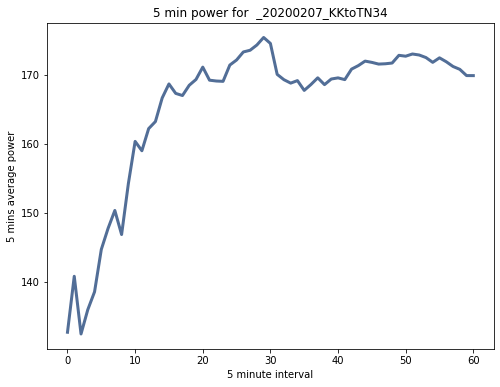

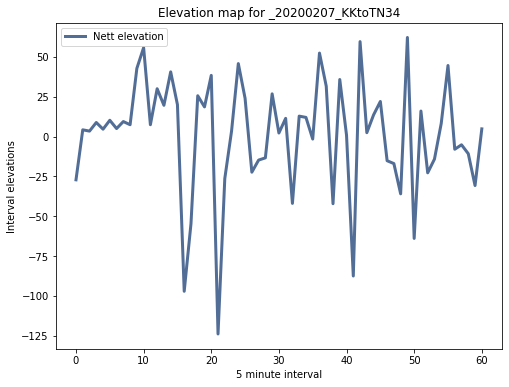

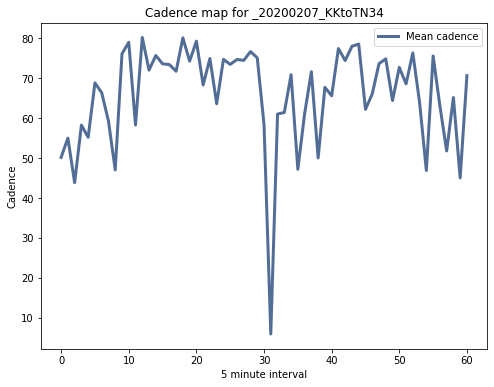

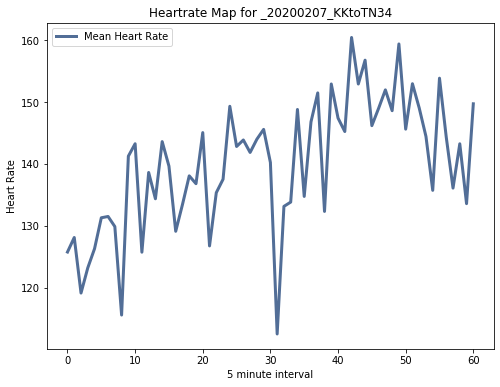

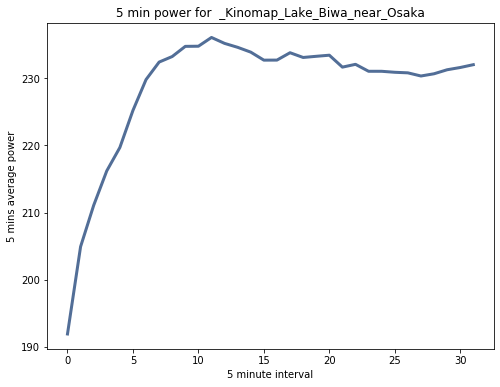

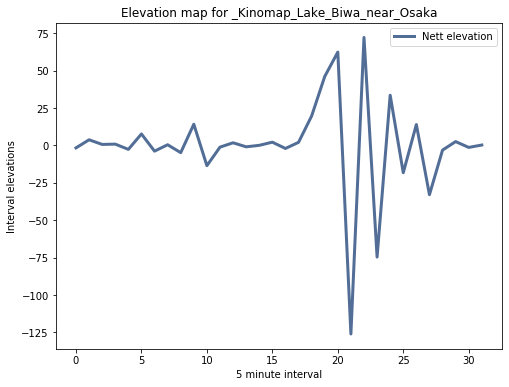

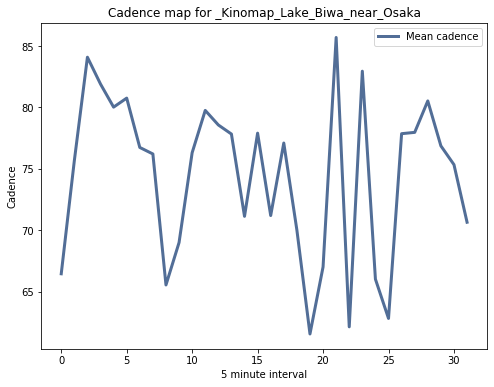

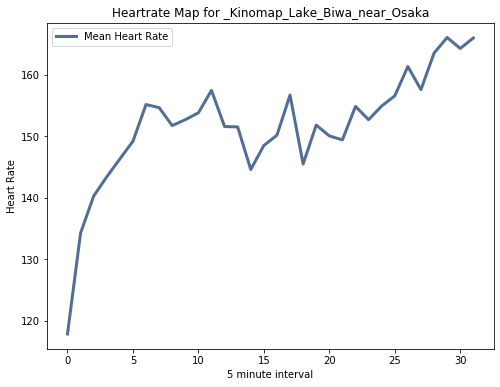

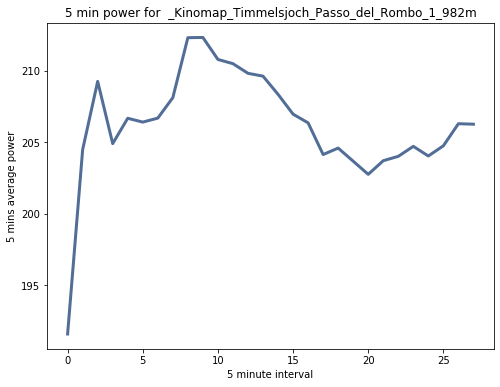

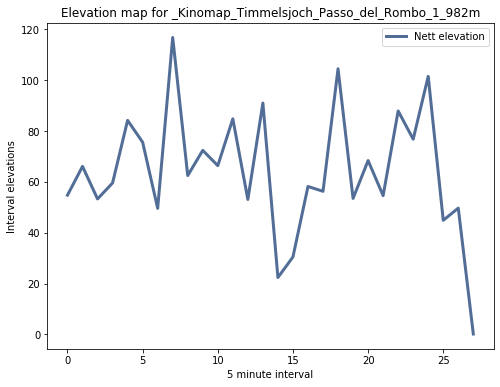

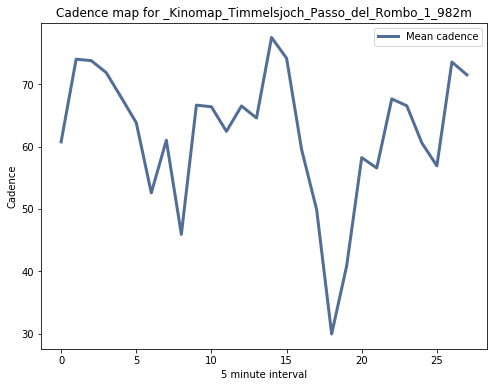

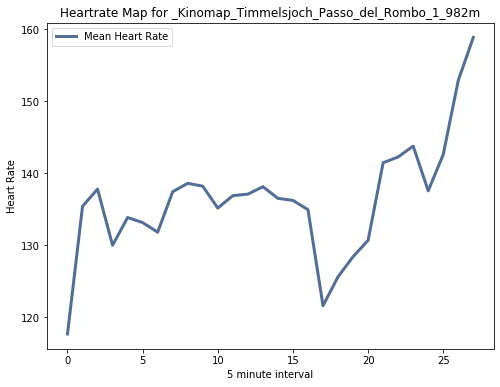

<Figure size 576x432 with 0 Axes>

In [81]:
tp.Plot(0,0)
tp.Show()

for index,val in intervals.index.get_level_values(0).value_counts().items():

    tp.Plot(intervals.loc[[index]].index.get_level_values(1),intervals.loc[[index],['5minutespower']])
    tp.config(title='5 min power for  '+index,xlabel='5 minute interval',ylabel='5 mins average power')
    tp.Show()
    tp.Plot(intervals.loc[[index]].index.get_level_values(1),intervals.loc[[index],['Elevation']],label='Nett elevation')
    #tp.Plot(intervals.loc[[index]].index.get_level_values(1),intervals.loc[[index],['elepos']],label='Climb')
    #tp.Plot(intervals.loc[[index]].index.get_level_values(1),intervals.loc[[index],['eleneg']],label='Descend')    
    tp.config(title='Elevation map for '+index,xlabel='5 minute interval',ylabel='Interval elevations')
    tp.Show()
    tp.Plot(intervals.loc[[index]].index.get_level_values(1),intervals.loc[[index],['Cadence']],label='Mean cadence')
    tp.config(title='Cadence map for '+index,xlabel='5 minute interval',ylabel='Cadence')
    tp.Show()    
    tp.Plot(intervals.loc[[index]].index.get_level_values(1),intervals.loc[[index],['HeartRate']],label='Mean Heart Rate')
    tp.config(title='Heartrate Map for '+index,xlabel='5 minute interval',ylabel='Heart Rate')
    tp.Show()        

In [148]:
intervals['interval'] = np.floor((intervals.ElapsedDuration+1) / 3600).apply(lambda x: '{:02d}'.format(int(x))) \
        + ':' \
        + np.floor((intervals.ElapsedDuration + 1 - np.floor((intervals.ElapsedDuration + 1) / 3600) * 3600) / 60).apply(lambda x: '{:02d}'.format(int(x)))



In [167]:
#Determine heartrate runs

def hrzone(heartrate):
    if heartrate <= 120:
        return '1. Up to 120'
    elif heartrate <= 140:
        return '2. 120 to 140'
    elif heartrate <= 160:
        return '3. 140 to 160'
    elif heartrate <= 170:
        return '4. 160 to 170'
    elif heartrate <= 175:
        return '5. 170 to 175'
    else:
        return '6. over 175'
    return '0. no heartrate'


In [168]:
cycledf['hrzone']=cycledf.HeartRate.apply(hrzone)

cycledf['nexthrzone']=cycledf.hrzone.shift(periods = -1)    

cycledf['prevhrzone']=cycledf.hrzone.shift(periods = 1)

cycledf['zonestart'] = (cycledf.hrzone != cycledf.prevhrzone) * 1
cycledf['zoneend'] =  (cycledf.hrzone != cycledf.nexthrzone) * 1

In [234]:
cycledf['zoneid']=cycledf.zonestart.cumsum()
cycledf['zoneduration']=cycledf.groupby(['zoneid']).cumsum()['Duration']

In [235]:
hrzonedf = pd.DataFrame(cycledf.groupby(['zoneid','hrzone']).max()[['zoneduration']])

In [236]:
counter = 1
for index,row in hrzonedf.query('hrzone == "6. over 175"').sort_values(by=['zoneduration'],ascending=False).iterrows():
    print(counter,index[0],index[1],row.zoneduration)
    counter+=1

1 377 6. over 175 93.0
2 402 6. over 175 66.0
3 386 6. over 175 63.0
4 395 6. over 175 31.0
5 658 6. over 175 14.0


In [176]:
hrzonedf.groupby(['hrzone']).zoneduration.sum()/60

hrzone
1. Up to 120      72.733333
2. 120 to 140    324.100000
3. 140 to 160    483.366667
4. 160 to 170     64.516667
5. 170 to 175      3.100000
6. over 175        4.450000
Name: zoneduration, dtype: float64

In [190]:
cycledf.head

<bound method NDFrame.head of        Unnamed: 0 FileType  RowId  \
0               0      gpx      1   
1               1      gpx      2   
2               2      gpx      3   
3               3      gpx      4   
4               4      gpx      5   
...           ...      ...    ...   
56210       56210      gpx   8119   
56211       56211      gpx   8120   
56212       56212      gpx   8121   
56213       56213      gpx   8122   
56214       56214      gpx   8123   

                                        ActivityId                 Time  \
0                               _20200207_KKtoTN34  2020-02-07 12:10:18   
1                               _20200207_KKtoTN34  2020-02-07 12:10:19   
2                               _20200207_KKtoTN34  2020-02-07 12:10:20   
3                               _20200207_KKtoTN34  2020-02-07 12:10:21   
4                               _20200207_KKtoTN34  2020-02-07 12:10:22   
...                                            ...                  ...   


In [179]:
cycledf['simplerungradient'] = np.round(cycledf.RunGradient*100,0)

cycledf.simplerungradient

0        NaN
1        0.0
2        0.0
3       -2.0
4       -2.0
        ... 
56210    NaN
56211    NaN
56212    NaN
56213    NaN
56214    NaN
Name: simplerungradient, Length: 56215, dtype: float64

In [221]:
gradients = pd.DataFrame(cycledf[(cycledf.RunEnd == 1) & (cycledf.RunGradient >= -0.3) & (cycledf.RunGradient <= 0.3)].groupby(['simplerungradient']).RunDuration.sum()/cycledf.Duration.sum())

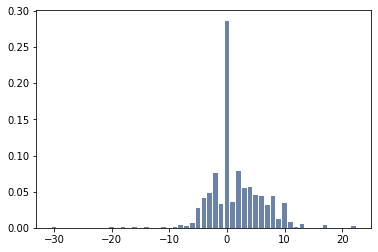

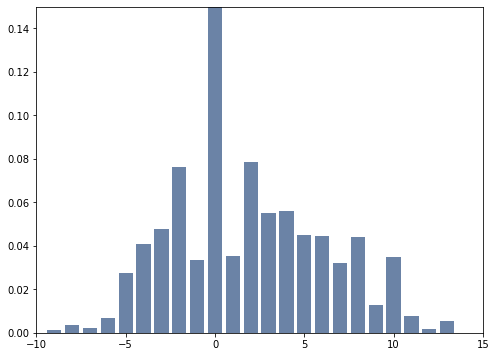

<Figure size 576x432 with 0 Axes>

In [232]:
tp.Bar(gradients.index,gradients.RunDuration)
tp.Config(ylimit=(0,15),xlimit=(-10,15))
tp.Show()
tp.Bar(gradients.index,gradients.RunDuration)
tp.Config(ylim=(0,0.15),xlim=(-10,15))
tp.Show()

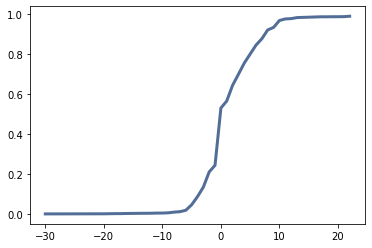

<Figure size 576x432 with 0 Axes>

In [225]:
gradients['cumulative']=gradients.RunDuration.cumsum()

tp.Plot(gradients.index,gradients.cumulative)
tp.Show()


In [212]:
gradienthist

Hist({49.0: 2, 4495.0: 1, 72.0: 1, 2025.0: 1, 1908.0: 1, 1578.0: 1, 387.0: 1, 135.0: 1, 194.0: 1, 5.0: 1, 4361.0: 1, 20.0: 1, 28.0: 1, 8.0: 1, 1.0: 1, 52.0: 1, 33.0: 1, 3212.0: 1, 2554.0: 1, 2573.0: 1, 1829.0: 1, 3159.0: 1, 16380.0: 1, 2721.0: 1, 2325.0: 1, 118.0: 1, 15.0: 1, 21.0: 1, 6.0: 1, 223.0: 1, 299.0: 1, 89.0: 1, 446.0: 1, 1983.0: 1, 721.0: 1, 2518.0: 1, 25.0: 1})